# Геморное домашнее задание №1

<img src='https://i0.wp.com/media4.giphy.com/media/AlBHDuku3H7fG/giphy.gif'><br>

# Загрузка данных

In [385]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

/kaggle/input/hw-multiclass-classification/sub_baseline.csv
/kaggle/input/hw-multiclass-classification/train.csv
/kaggle/input/hw-multiclass-classification/test.csv


In [386]:
train = pd.read_csv('/kaggle/input/hw-multiclass-classification/train.csv', sep=';')
test = pd.read_csv('/kaggle/input/hw-multiclass-classification/test.csv', sep=';')
submission = pd.read_csv('/kaggle/input/hw-multiclass-classification/sub_baseline.csv')

In [387]:
'train: ', train.shape, 'test: ', test.shape #оцениваем размер

('train: ', (39481, 15), 'test: ', (9871, 14))

Результат нужно сохранить в **csv файл с двумя колонками**: 

listing_id - берете из датасета

interest_level - проставляете своим алгоритмом

Разделитель **запятая**, при сохранении с помощью result.to_csv() - не забывайте указывать index=None.

In [388]:
submission.head()  

listing_id  interest_level
0     7077863               0
1     7089371               0
2     7210791               0
3     6817348               0
4     7149366               0

## Анализ данных
## 1. Предобработка и генерация признаков

Для выполнения задания попробуйте придумать признаки на основе имеющихся данных, для работы с текстовыми полями вам может пригодится LabelEncoder/OneHotEncoder, re.sub(),re.findall() 

Ниже представлены имеющиеся у нас признаки. Можно попробовать сгенерировать из них новые. Например, можно сделать признак Стоимость за комнату, признаки на основе значений в features, выделить и закодировать адрес, так же можно попробовать оценить "успешность" менеджера, предположив, что чем больше объявлений у данного manager_id - тем он круче.

In [389]:
train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level'],
      dtype='object')

In [390]:
train.head()

bathrooms  bedrooms                       building_id              created  \
0        1.0         0  cb0ecd5356125b546833239efdb154c2  2016-06-02 04:21:46   
1        1.0         2  4df46d9768a98df24200a2e7693370bd  2016-05-26 05:44:12   
2        1.0         0                                 0  2016-06-17 01:22:32   
3        1.0         1  78e50c94b33bb1ceeb5f4c8ff7455703  2016-06-03 05:26:40   
4        2.0         0  e87f1236b102798c1fa104a372800444  2016-04-12 04:10:28   

                                         description   display_address  \
0          AMAZING STUDIO!! CONVENIENT TO ALL - G...       Gold Street   
1  Near NYU, Washington SQ Park, centrally locate...   Thompson Street   
2  RENT STABILIZED! FULL TIME DOORMAN.LEXINGTON A...  East 35th Street   
3  WHY TO LIVE IN THIS LUXURIOUS BUILDING? WEEKDA...  West 42nd Street   
4          Listed on the National Register of His...  Greenwich Street   

                                            features  latitude  listing_id  \
0                   ['Cats Allowed', 'Dogs Allowed']   40.6969     7097709   
1                                                 []   40.7264     7071860   
2        ['Doorman', 'Dogs Allowed', 'Cats Allowed']   40.7466     7174524   
3  ['Swimming Pool', 'Roof Deck', 'Dining Room', ...   40.7610     7104515   
4            ['Doorman', 'Fitness Center', 'No Fee']   40.7324     6859942   

   longitude                        manager_id  \
0   -73.9830  79d1809d224bc7f26c719f247d6c8dc6   
1   -74.0013  e60b02e0cfd2eea7d777bb283d6f8d4d   
2   -73.9779  91a276fdb4c7ae5ff56fd0884b5121db   
3   -73.9992  cbcd513212d592e6c717d27be14f46ac   
4   -74.0081  b209e2c4384a64cc307c26759ee0c651   

                                              photos  price  \
0  ['https://photos.renthop.com/2/7097709_8f74305...   2575   
1  ['https://photos.renthop.com/2/7071860_32b196a...   3250   
2  ['https://photos.renthop.com/2/7174524_bde8df9...   2448   
3  ['https://photos.renthop.com/2/7104515_bab0753...   3300   
4  ['https://photos.renthop.com/2/6859942_16f88f7...   5450   

         street_address interest_level  
0       257 Gold Street            low  
1   128 Thompson Street           high  
2  165 East 35th Street            low  
3  610 West 42nd Street            low  
4  666 Greenwich Street            low

In [391]:
train.interest_level.value_counts()

low       27446
medium     8941
high       3094
Name: interest_level, dtype: int64

In [392]:
train.interest_level.value_counts(normalize=True)

low       0.695170
medium    0.226463
high      0.078367
Name: interest_level, dtype: float64

**Строки превращаем обратно в список**

In [393]:
train.features

0                         ['Cats Allowed', 'Dogs Allowed']
1                                                       []
2              ['Doorman', 'Dogs Allowed', 'Cats Allowed']
3        ['Swimming Pool', 'Roof Deck', 'Dining Room', ...
4                  ['Doorman', 'Fitness Center', 'No Fee']
                               ...                        
39476                     ['Dogs Allowed', 'Cats Allowed']
39477    ['Swimming Pool', 'Doorman', 'Elevator', 'Fitn...
39478                       ['Elevator', 'Fitness Center']
39479    ['Pre-War', 'Laundry in Unit', 'Dishwasher', '...
39480    ['Doorman', 'Fitness Center', 'Elevator', 'Sto...
Name: features, Length: 39481, dtype: object

In [394]:
train['features']=train['features'].str.replace('[\[\]\']', '').str.split(', ')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [395]:
train['features']

0                             [Cats Allowed, Dogs Allowed]
1                                                       []
2                    [Doorman, Dogs Allowed, Cats Allowed]
3        [Swimming Pool, Roof Deck, Dining Room, Doorma...
4                        [Doorman, Fitness Center, No Fee]
                               ...                        
39476                         [Dogs Allowed, Cats Allowed]
39477    [Swimming Pool, Doorman, Elevator, Fitness Cen...
39478                           [Elevator, Fitness Center]
39479    [Pre-War, Laundry in Unit, Dishwasher, Hardwoo...
39480    [Doorman, Fitness Center, Elevator, Storage, P...
Name: features, Length: 39481, dtype: object

In [396]:
train['num_features']=train['features'].apply(len)

Фотографии можно спарсить по ссылкам, но т.к. обработка изображений в этой домашке не в приоритете, можно просто посчитать количество фотографий.

In [397]:
train['photos']=train['photos'].str.replace('[\[\]\']', '').str.split(', ')
train['num_photos']=train['photos'].apply(len)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


Делаем самые простые фичи. В данном случае просто считаем кол-во слов в описании.

В датасете присутствуют NaN, поэтому предварительно заполняем пропуски пустыми строками.

In [398]:
train["num_description_words"]=train["description"].fillna('').apply(lambda x: len(x.split(" ")))

Может быть заинтересованность объявлением зависит от времени года или времени публикации?

In [399]:
train["created"]

0        2016-06-02 04:21:46
1        2016-05-26 05:44:12
2        2016-06-17 01:22:32
3        2016-06-03 05:26:40
4        2016-04-12 04:10:28
                ...         
39476    2016-06-20 18:09:47
39477    2016-04-26 05:40:27
39478    2016-04-10 03:20:09
39479    2016-06-03 03:53:35
39480    2016-06-15 02:29:10
Name: created, Length: 39481, dtype: object

In [400]:
train["created"] = pd.to_datetime(train["created"])
train["created_year"] = train["created"].dt.year
train["created_month"] = train["created"].dt.month
train["created_day"] = train["created"].dt.day
train["created_hour"] = train["created"].dt.hour

<AxesSubplot:xlabel='index'>

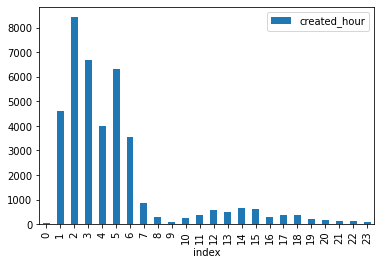

In [401]:
hours=train["created_hour"].value_counts().reset_index().sort_values(by='index')
hours.plot(x='index', y='created_hour', kind='bar')

не похоже что стоит использовать created_month в модели

<AxesSubplot:xlabel='index'>

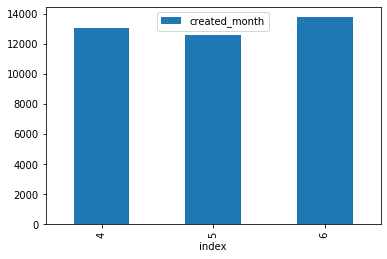

In [402]:
months=train["created_month"].value_counts().reset_index().sort_values(by='index')
months.plot(x='index', y='created_month', kind='bar')

In [403]:
train.head()

bathrooms  bedrooms                       building_id             created  \
0        1.0         0  cb0ecd5356125b546833239efdb154c2 2016-06-02 04:21:46   
1        1.0         2  4df46d9768a98df24200a2e7693370bd 2016-05-26 05:44:12   
2        1.0         0                                 0 2016-06-17 01:22:32   
3        1.0         1  78e50c94b33bb1ceeb5f4c8ff7455703 2016-06-03 05:26:40   
4        2.0         0  e87f1236b102798c1fa104a372800444 2016-04-12 04:10:28   

                                         description   display_address  \
0          AMAZING STUDIO!! CONVENIENT TO ALL - G...       Gold Street   
1  Near NYU, Washington SQ Park, centrally locate...   Thompson Street   
2  RENT STABILIZED! FULL TIME DOORMAN.LEXINGTON A...  East 35th Street   
3  WHY TO LIVE IN THIS LUXURIOUS BUILDING? WEEKDA...  West 42nd Street   
4          Listed on the National Register of His...  Greenwich Street   

                                            features  latitude  listing_id  \
0                       [Cats Allowed, Dogs Allowed]   40.6969     7097709   
1                                                 []   40.7264     7071860   
2              [Doorman, Dogs Allowed, Cats Allowed]   40.7466     7174524   
3  [Swimming Pool, Roof Deck, Dining Room, Doorma...   40.7610     7104515   
4                  [Doorman, Fitness Center, No Fee]   40.7324     6859942   

   longitude  ... price        street_address  interest_level num_features  \
0   -73.9830  ...  2575       257 Gold Street             low            2   
1   -74.0013  ...  3250   128 Thompson Street            high            1   
2   -73.9779  ...  2448  165 East 35th Street             low            3   
3   -73.9992  ...  3300  610 West 42nd Street             low           16   
4   -74.0081  ...  5450  666 Greenwich Street             low            3   

  num_photos  num_description_words  created_year  created_month  created_day  \
0         10                    381          2016              6            2   
1          5                     19          2016              5           26   
2          1                     86          2016              6           17   
3          6                    131          2016              6            3   
4          8                     81          2016              4           12   

   created_hour  
0             4  
1             5  
2             1  
3             5  
4             4  

[5 rows x 22 columns]

In [404]:
train.num_description_words.value_counts()

9      1376
1      1147
93      370
84      333
71      331
       ... 
358       1
291       1
667       1
321       1
331       1
Name: num_description_words, Length: 412, dtype: int64

<AxesSubplot:xlabel='interest_level', ylabel='count'>

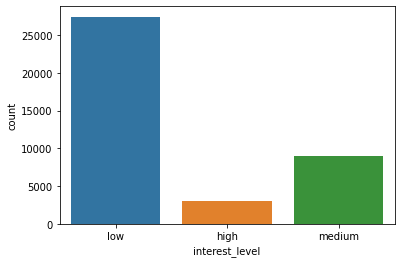

In [405]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.countplot(x='interest_level', data=train)

Видим, что в большинстве случаев спрос низкий

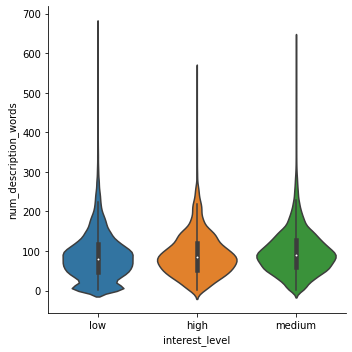

In [406]:
#sns.violinplot(x='interest_level', hue='num_description_words', data=train, palette='rainbow')
sns.catplot(x='interest_level', y='num_description_words', kind='violin', data=train);

По этому графику можно отметить, что у низкого спроса нижний квартиль ниже, чем высокого и среднего. Но и разброс очень сильный. У среднего верхний квартиль выше остальных.

In [407]:
train.bedrooms.value_counts()

1    12589
2    11597
0     7668
3     5850
4     1526
5      209
6       38
8        2
7        2
Name: bedrooms, dtype: int64

<AxesSubplot:xlabel='interest_level', ylabel='count'>

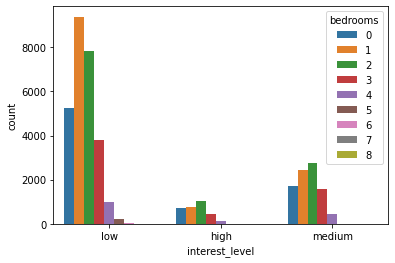

In [408]:
#sns.catplot(x='interest_level', y='bedrooms',  data=train)
sns.countplot(x='interest_level',hue='bedrooms', data=train)

Видим, что однокомнатные квартиры в большинстве не пользуются спросом

In [409]:
train.price.value_counts()

2500    875
3200    703
3000    664
2700    640
2400    634
       ... 
5073      1
2449      1
2703      1
1756      1
4758      1
Name: price, Length: 2552, dtype: int64

In [410]:
train['price'].mean()

3751.991970821408

In [411]:
train.num_photos.value_counts()

5     6937
4     6244
6     5399
7     3980
1     3843
3     3656
8     3179
9     1453
10    1119
2     1087
12     650
11     622
13     310
14     187
15     149
16     133
18      93
17      81
20      68
32      56
22      50
19      45
21      19
26      17
37      15
25      14
24      13
23      12
28      10
27       6
45       6
38       5
30       5
36       3
29       3
34       2
46       2
35       2
68       1
44       1
60       1
50       1
43       1
31       1
Name: num_photos, dtype: int64

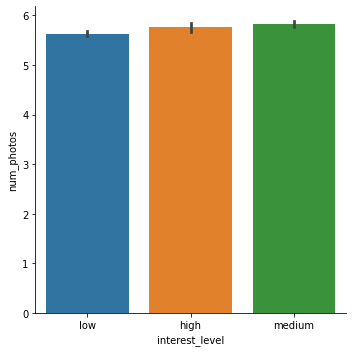

In [412]:
sns.catplot(x='interest_level', y='num_photos', kind='bar', data=train);

В Seaborn функция barplot() по умолчанию отображает среднее значение величины внутри каждой категории и отображает ее доверительный интервал. Видим, что у высокого и среднего спроса количество фотографий больше.

In [413]:
train.head()

bathrooms  bedrooms                       building_id             created  \
0        1.0         0  cb0ecd5356125b546833239efdb154c2 2016-06-02 04:21:46   
1        1.0         2  4df46d9768a98df24200a2e7693370bd 2016-05-26 05:44:12   
2        1.0         0                                 0 2016-06-17 01:22:32   
3        1.0         1  78e50c94b33bb1ceeb5f4c8ff7455703 2016-06-03 05:26:40   
4        2.0         0  e87f1236b102798c1fa104a372800444 2016-04-12 04:10:28   

                                         description   display_address  \
0          AMAZING STUDIO!! CONVENIENT TO ALL - G...       Gold Street   
1  Near NYU, Washington SQ Park, centrally locate...   Thompson Street   
2  RENT STABILIZED! FULL TIME DOORMAN.LEXINGTON A...  East 35th Street   
3  WHY TO LIVE IN THIS LUXURIOUS BUILDING? WEEKDA...  West 42nd Street   
4          Listed on the National Register of His...  Greenwich Street   

                                            features  latitude  listing_id  \
0                       [Cats Allowed, Dogs Allowed]   40.6969     7097709   
1                                                 []   40.7264     7071860   
2              [Doorman, Dogs Allowed, Cats Allowed]   40.7466     7174524   
3  [Swimming Pool, Roof Deck, Dining Room, Doorma...   40.7610     7104515   
4                  [Doorman, Fitness Center, No Fee]   40.7324     6859942   

   longitude  ... price        street_address  interest_level num_features  \
0   -73.9830  ...  2575       257 Gold Street             low            2   
1   -74.0013  ...  3250   128 Thompson Street            high            1   
2   -73.9779  ...  2448  165 East 35th Street             low            3   
3   -73.9992  ...  3300  610 West 42nd Street             low           16   
4   -74.0081  ...  5450  666 Greenwich Street             low            3   

  num_photos  num_description_words  created_year  created_month  created_day  \
0         10                    381          2016              6            2   
1          5                     19          2016              5           26   
2          1                     86          2016              6           17   
3          6                    131          2016              6            3   
4          8                     81          2016              4           12   

   created_hour  
0             4  
1             5  
2             1  
3             5  
4             4  

[5 rows x 22 columns]

In [414]:
train.num_features.value_counts()

1     6073
3     4944
4     4366
2     3921
5     3641
6     3069
7     2689
8     2292
9     1979
10    1792
11    1357
12    1079
13     811
14     582
15     353
16     231
17     131
18      64
19      38
20      20
21      13
22      12
26       6
23       5
28       3
27       2
24       2
25       2
39       1
36       1
32       1
31       1
Name: num_features, dtype: int64

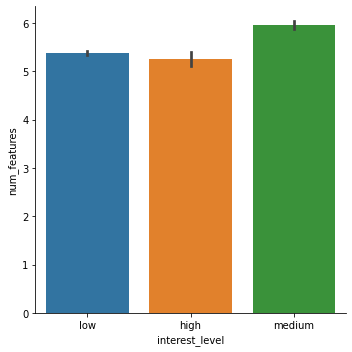

In [415]:
sns.catplot(x='interest_level', y='num_features', kind='bar', data=train);

По графику видим, что доверительный интервал у высого спроса больше остальных

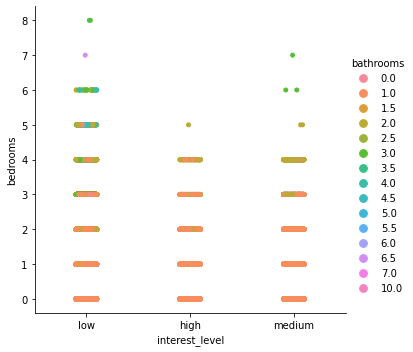

In [416]:
sns.catplot(x='interest_level',
            y='bedrooms',
            hue='bathrooms',
            data=train);

In [417]:
target = 'interest_level'

In [418]:
features = ['num_features', 'num_photos', 'price', 'num_description_words', 'bedrooms', 'bathrooms', 'latitude' , 'longitude']

In [419]:
from sklearn.preprocessing import OneHotEncoder
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(train[["interest_level"]])
oe_results.toarray()

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [420]:
#pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_).head()

In [421]:
train.head()

bathrooms  bedrooms                       building_id             created  \
0        1.0         0  cb0ecd5356125b546833239efdb154c2 2016-06-02 04:21:46   
1        1.0         2  4df46d9768a98df24200a2e7693370bd 2016-05-26 05:44:12   
2        1.0         0                                 0 2016-06-17 01:22:32   
3        1.0         1  78e50c94b33bb1ceeb5f4c8ff7455703 2016-06-03 05:26:40   
4        2.0         0  e87f1236b102798c1fa104a372800444 2016-04-12 04:10:28   

                                         description   display_address  \
0          AMAZING STUDIO!! CONVENIENT TO ALL - G...       Gold Street   
1  Near NYU, Washington SQ Park, centrally locate...   Thompson Street   
2  RENT STABILIZED! FULL TIME DOORMAN.LEXINGTON A...  East 35th Street   
3  WHY TO LIVE IN THIS LUXURIOUS BUILDING? WEEKDA...  West 42nd Street   
4          Listed on the National Register of His...  Greenwich Street   

                                            features  latitude  listing_id  \
0                       [Cats Allowed, Dogs Allowed]   40.6969     7097709   
1                                                 []   40.7264     7071860   
2              [Doorman, Dogs Allowed, Cats Allowed]   40.7466     7174524   
3  [Swimming Pool, Roof Deck, Dining Room, Doorma...   40.7610     7104515   
4                  [Doorman, Fitness Center, No Fee]   40.7324     6859942   

   longitude  ... price        street_address  interest_level num_features  \
0   -73.9830  ...  2575       257 Gold Street             low            2   
1   -74.0013  ...  3250   128 Thompson Street            high            1   
2   -73.9779  ...  2448  165 East 35th Street             low            3   
3   -73.9992  ...  3300  610 West 42nd Street             low           16   
4   -74.0081  ...  5450  666 Greenwich Street             low            3   

  num_photos  num_description_words  created_year  created_month  created_day  \
0         10                    381          2016              6            2   
1          5                     19          2016              5           26   
2          1                     86          2016              6           17   
3          6                    131          2016              6            3   
4          8                     81          2016              4           12   

   created_hour  
0             4  
1             5  
2             1  
3             5  
4             4  

[5 rows x 22 columns]

In [422]:
mapper={
        'low':0,
        'medium':1,
        'high':2
       }

train['interest_level'] = train['interest_level'].apply(lambda x: mapper[x])

In [423]:
train.head()

bathrooms  bedrooms                       building_id             created  \
0        1.0         0  cb0ecd5356125b546833239efdb154c2 2016-06-02 04:21:46   
1        1.0         2  4df46d9768a98df24200a2e7693370bd 2016-05-26 05:44:12   
2        1.0         0                                 0 2016-06-17 01:22:32   
3        1.0         1  78e50c94b33bb1ceeb5f4c8ff7455703 2016-06-03 05:26:40   
4        2.0         0  e87f1236b102798c1fa104a372800444 2016-04-12 04:10:28   

                                         description   display_address  \
0          AMAZING STUDIO!! CONVENIENT TO ALL - G...       Gold Street   
1  Near NYU, Washington SQ Park, centrally locate...   Thompson Street   
2  RENT STABILIZED! FULL TIME DOORMAN.LEXINGTON A...  East 35th Street   
3  WHY TO LIVE IN THIS LUXURIOUS BUILDING? WEEKDA...  West 42nd Street   
4          Listed on the National Register of His...  Greenwich Street   

                                            features  latitude  listing_id  \
0                       [Cats Allowed, Dogs Allowed]   40.6969     7097709   
1                                                 []   40.7264     7071860   
2              [Doorman, Dogs Allowed, Cats Allowed]   40.7466     7174524   
3  [Swimming Pool, Roof Deck, Dining Room, Doorma...   40.7610     7104515   
4                  [Doorman, Fitness Center, No Fee]   40.7324     6859942   

   longitude  ... price        street_address  interest_level num_features  \
0   -73.9830  ...  2575       257 Gold Street               0            2   
1   -74.0013  ...  3250   128 Thompson Street               2            1   
2   -73.9779  ...  2448  165 East 35th Street               0            3   
3   -73.9992  ...  3300  610 West 42nd Street               0           16   
4   -74.0081  ...  5450  666 Greenwich Street               0            3   

   num_photos  num_description_words  created_year  created_month  \
0          10                    381          2016              6   
1           5                     19          2016              5   
2           1                     86          2016              6   
3           6                    131          2016              6   
4           8                     81          2016              4   

   created_day  created_hour  
0            2             4  
1           26             5  
2           17             1  
3            3             5  
4           12             4  

[5 rows x 22 columns]

Т.к. в столбце interest_level находятся не числа, а строки, когда остальные отобранные нами признаки являются числами.

In [424]:
train[features].head()

num_features  num_photos  price  num_description_words  bedrooms  \
0             2          10   2575                    381         0   
1             1           5   3250                     19         2   
2             3           1   2448                     86         0   
3            16           6   3300                    131         1   
4             3           8   5450                     81         0   

   bathrooms  latitude  longitude  
0        1.0   40.6969   -73.9830  
1        1.0   40.7264   -74.0013  
2        1.0   40.7466   -73.9779  
3        1.0   40.7610   -73.9992  
4        2.0   40.7324   -74.0081

## 2. Тестирование различных алгоритмов

Для выполнения этой части задания разбейте размеченные данные на train и test и напишите автоматическое тестирование разных алгоритмов классификации в цикле с вычислением метрики f1_score('macro')

Метрику на тесте по разным алгоритмам сохраняйте в датафрейм или выводите

In [425]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, average_precision_score
import joblib

In [426]:
train[features].head()

num_features  num_photos  price  num_description_words  bedrooms  \
0             2          10   2575                    381         0   
1             1           5   3250                     19         2   
2             3           1   2448                     86         0   
3            16           6   3300                    131         1   
4             3           8   5450                     81         0   

   bathrooms  latitude  longitude  
0        1.0   40.6969   -73.9830  
1        1.0   40.7264   -74.0013  
2        1.0   40.7466   -73.9779  
3        1.0   40.7610   -73.9992  
4        2.0   40.7324   -74.0081

Изменяйте параметры алгоритмов на свое усмотрение, можете добавлять свои алгоритмы

In [427]:
classifiers = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'MLPClassifier': MLPClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
    'XGBClassifier': XGBClassifier(),

}

Выполним масштабирование данных

In [428]:
from sklearn.preprocessing import StandardScaler, Normalizer

In [429]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train[features])

len(features)

8

In [430]:
pd.DataFrame(scaled_train).describe()

0             1             2             3             4  \
count  3.948100e+04  3.948100e+04  3.948100e+04  3.948100e+04  3.948100e+04   
mean  -1.583743e-17  3.653407e-17 -1.421769e-17 -5.723072e-17 -6.712911e-17   
std    1.000013e+00  1.000013e+00  1.000013e+00  1.000013e+00  1.000013e+00   
min   -1.170683e+00 -1.324878e+00 -3.760954e-01 -1.497272e+00 -1.375142e+00   
25%   -9.102595e-01 -4.768131e-01 -1.270546e-01 -6.762260e-01 -4.812998e-01   
50%   -1.289883e-01 -1.941249e-01 -6.104257e-02 -1.065204e-01 -4.812998e-01   
75%    6.522830e-01  3.712517e-01  3.528835e-02  4.966972e-01  4.125426e-01   
max    8.725419e+00  1.761524e+01  1.162307e+02  9.662255e+00  5.775597e+00   

                  5             6             7  
count  3.948100e+04  3.948100e+04  3.948100e+04  
mean   3.131492e-17  6.921857e-15 -3.478116e-15  
std    1.000013e+00  1.000013e+00  1.000013e+00  
min   -2.413582e+00 -5.713254e+01 -3.370056e+01  
25%   -4.234474e-01 -1.509598e-02 -3.084911e-02  
50%   -4.234474e-01  1.800079e-02 -2.035567e-02  
75%   -4.234474e-01  4.955491e-02 -2.714530e-03  
max    1.748776e+01  5.812319e+00  5.623200e+01

In [431]:
#Делим выборку на train и test, 
X_train, X_test, y_train, y_test = train_test_split(scaled_train, train[target],
                                                    test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27636, 8), (11845, 8), (27636,), (11845,))

In [432]:
for name, model in classifiers.items():
    print(name)
    
    model.fit(X_train, y_train)
    predicts = model.predict(X_test)
    f1 = f1_score(y_test, predicts, average = 'macro')
        
    print('На отложенной тестовой выборке: ')
    print('%s: F_мера: %7.5f ' % 
       (name, f1))
    print('-'*30)
    
    

KNeighborsClassifier
На отложенной тестовой выборке: 
KNeighborsClassifier: F_мера: 0.37053 
------------------------------
DecisionTreeClassifier
На отложенной тестовой выборке: 
DecisionTreeClassifier: F_мера: 0.47660 
------------------------------
RandomForestClassifier
На отложенной тестовой выборке: 
RandomForestClassifier: F_мера: 0.50898 
------------------------------
MLPClassifier


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


На отложенной тестовой выборке: 
MLPClassifier: F_мера: 0.48999 
------------------------------
AdaBoostClassifier
На отложенной тестовой выборке: 
AdaBoostClassifier: F_мера: 0.42707 
------------------------------
GaussianNB
На отложенной тестовой выборке: 
GaussianNB: F_мера: 0.21031 
------------------------------
QuadraticDiscriminantAnalysis
На отложенной тестовой выборке: 
QuadraticDiscriminantAnalysis: F_мера: 0.19987 
------------------------------
XGBClassifier
На отложенной тестовой выборке: 
XGBClassifier: F_мера: 0.51652 
------------------------------


# **RandomForestClassifier**

In [433]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
model.fit(X_train, y_train)  #обучаем модель
prediction = model.predict(X_test) #делаем предсказание

In [434]:
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score, classification_report, precision_score, recall_score

In [435]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      8221
           1       0.45      0.28      0.35      2731
           2       0.46      0.26      0.33       893

    accuracy                           0.72     11845
   macro avg       0.56      0.48      0.51     11845
weighted avg       0.68      0.72      0.69     11845



# **LogisticRegression**

In [436]:
logistic_regression = LogisticRegression()

logistic_regression.fit(X_train, y_train)
prediction = logistic_regression.predict(X_test)

In [437]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.70      0.98      0.82      8221
           1       0.36      0.06      0.10      2731
           2       0.20      0.00      0.00       893

    accuracy                           0.69     11845
   macro avg       0.42      0.35      0.31     11845
weighted avg       0.59      0.69      0.59     11845



# **XGBClassifier**

In [438]:
xgb = XGBClassifier(n_estimators=100, seed=42)
xgb.fit(X_train, y_train)
predicts = xgb.predict(X_test)

print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.78      0.92      0.85      8221
           1       0.47      0.30      0.37      2731
           2       0.50      0.26      0.34       893

    accuracy                           0.73     11845
   macro avg       0.58      0.49      0.52     11845
weighted avg       0.69      0.73      0.70     11845



# **Linear SVC**

In [439]:
from sklearn.svm import LinearSVC

In [440]:
scv = LinearSVC(random_state = 42)
scv.fit(X_train, y_train)
predicts = scv.predict(X_test)

print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.70      0.99      0.82      8221
           1       0.38      0.02      0.03      2731
           2       0.00      0.00      0.00       893

    accuracy                           0.69     11845
   macro avg       0.36      0.34      0.28     11845
weighted avg       0.57      0.69      0.58     11845



/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `

# **K-nearest neighbour**

In [441]:
from sklearn.neighbors import KNeighborsClassifier

In [442]:
kNN = KNeighborsClassifier(n_neighbors=20)
kNN.fit(X_train, y_train)
predicts = kNN.predict(X_test)

print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.71      0.96      0.81      8221
           1       0.37      0.09      0.14      2731
           2       0.20      0.00      0.01       893

    accuracy                           0.69     11845
   macro avg       0.43      0.35      0.32     11845
weighted avg       0.59      0.69      0.60     11845



In [443]:
from sklearn import tree

model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
predicts = model.predict(X_test)

print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      8221
           1       0.35      0.35      0.35      2731
           2       0.28      0.31      0.30       893

    accuracy                           0.64     11845
   macro avg       0.47      0.48      0.47     11845
weighted avg       0.65      0.64      0.64     11845



## 3. Отбор признаков

[Отбор признаков](https://scikit-learn.org/stable/modules/feature_selection.html)

[Recursive feature elimination](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py)

[SelectKBest + chi2](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

[L1-based feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel)

[ExtraTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeClassifier.html#sklearn.tree.ExtraTreeClassifier)

На выбор попробуйте выбрать самые важные признаки как минимум двумя разными способами (можно использовать те что выше или свой). Сравните способы по метрике f1 и average precision на тесте полученной делением размеченного файла.

**Ранжирование признаков с помощью Recursive Feature Elimination** 

In [444]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import RFECVrfecv = RFECV(estimator=GradientBoostingClassifier())

SyntaxError: invalid syntax (3935795951.py, line 8)

Метод с использованием Случайного Леса (Random Forest Importance)

<AxesSubplot:>

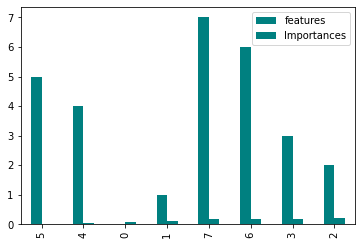

In [445]:
from sklearn.ensemble import RandomForestClassifier

# создаем случайное дерево с гипер параметрами
model = RandomForestClassifier(n_estimators=340)
model.fit(X_train, y_train)

# Подбираем самые важные признаки
importances = model.feature_importances_

# Создаем отдельный датасет для визуализации
final_df = pd.DataFrame({"features" : pd.DataFrame(X_train).columns, "Importances" : importances})
final_df.set_index('Importances')

# Сортируем их по возрастанию для лучшей визуализации
final_df = final_df.sort_values('Importances')

# Выводим на график
final_df.plot.bar(color = 'teal')

Абсолютное отклонение (Mean Absolute Difference, MAD)

<BarContainer object of 8 artists>

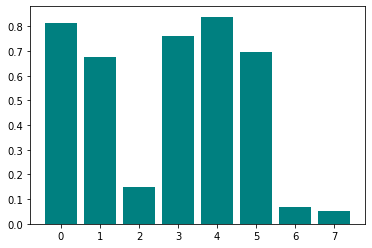

In [446]:
#import pandas as pd
#import numpy as np
#import matplotlib as plt
# Вычисляем MAD
# Где X - входные данные
mean_absolute_difference = np.sum(np.abs(X_train - np.mean(X_train, axis = 0)), axis = 0) / X_train.shape[0]

# график признаков
plt.bar(np.arange(X_train.shape[1]), mean_absolute_difference, color = 'teal')

## 4. Подбор гиперпараметров

Для этого задания подберите гиперпараметры как минимум для 3 алгоритмов из протестированных выше. Используйте Grid Search или Random Search, в качестве метрики передавайте f1_score

Не забывайте разбивать выборку на фолды, например с помощью StratifiedShuffleSplit.

In [447]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#clf = RandomForestClassifier()

In [ ]:
#grid = GridSearchCV(clf, features, cv=5)
#grid.fit(X_train, y_train)

In [448]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

In [449]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
params = {
    'max_depth': [2, 3, 4, 5],
    "min_samples_leaf": list(range(1, 5))
}

rf = RandomForestClassifier(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True)

dt_random_search = RandomizedSearchCV(rf, params, n_jobs=-1, cv=skf, verbose=1)
dt_random_search.fit(X_train, y_train)

print(dt_random_search.best_estimator_)
print(dt_random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)
{'min_samples_leaf': 1, 'max_depth': 5}


## 5. Стэкинг алгоритмов

Для выполнения этой части задания реализуйте стэкинг нечетного числа алгоритмов (больше одного конечно).

[Voting classifier](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)

[Stacked-generalization](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization)

In [450]:
from sklearn.ensemble import VotingClassifier

In [452]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = XGBClassifier()

eclf = VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
     voting='hard')
eclf.fit(X_train, y_train)
predicts = eclf.predict(X_test)
f1 = f1_score(y_test, predicts, average='macro')
print('На отложенной тестовой выборке: ')
print('%s: F_мера: %7.5f, ' % 
       ('Ensemble', f1))

На отложенной тестовой выборке: 
Ensemble: F_мера: 0.46296, 


## 6. Добавление номера кластера в качестве признака

Сделать кластеризацию данных хотя бы на числовых признаках, кластер добавить к данным в качестве признака и обучить на этом классификатор.

Сравнить метрику с кластером-признаком и без.

При использовании k-means нужно сделать подбор количества кластеров одним из способов The Elbow Method или The Silhouette Method. [Как же это сделать в питоне](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb)

In [453]:
from sklearn import datasets
from sklearn.cluster import KMeans



# Описываем модель
model = KMeans(n_clusters=3)

# Проводим моделирование
model.fit(X_train, y_train)

# Предсказание на всем наборе данных
all_predictions = model.predict(X_test)

# Выводим предсказания
print(all_predictions)

[0 0 0 ... 0 0 0]


## 7. Итоговое решение и сабмит 

Далее должно приводиться ваше итоговое решение, с лучшей метрикой на лидерборде, которой вам удалось добится. Можете сделать два ноутбука если так удобнее.

Выше произведенные действия не гарантируют хороший результат на лидерборде, для него нужно поэксперементировать самостоятельно ;) 

**! ВАЖНО: ваш итоговый результат должен быть как минимум выше baseline.**

## Baseline

In [454]:
features = ['num_features', 'num_photos', 'price', 'num_description_words', 'bedrooms', 'bathrooms', 'latitude' , 'longitude']
target='interest_level'

In [455]:
train=train.set_index('listing_id')
train_target=train[target]

In [456]:
X_train, X_test, y_train, y_test=train_test_split(train[features], train_target,
                                                  test_size=0.3, stratify=train_target, 
                                                  random_state=42)

In [457]:
y_train.value_counts(normalize=True)

0    0.695180
1    0.226444
2    0.078376
Name: interest_level, dtype: float64

In [458]:
y_test.value_counts(normalize=True)

0    0.695146
1    0.226509
2    0.078345
Name: interest_level, dtype: float64

In [459]:
model = XGBClassifier()
model.fit(train[features], train[target])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

## Подготовка submission

В плане предобработки\генерации признаков делаем все тоже самое. Потом предсказываем моделью значения.

In [460]:
test['features']=test['features'].str.replace('[\[\]\']', '').str.split(', ')
test['num_features']=test['features'].apply(len)
test['photos']=test['photos'].str.replace('[\[\]\']', '').str.split(', ')
test['num_photos']=test['photos'].apply(len)
test["num_description_words"]=test["description"].fillna('').apply(lambda x: len(x.split(" ")))
test["created"] = pd.to_datetime(test["created"])
test["created_year"] = test["created"].dt.year
test["created_month"] = test["created"].dt.month
test["created_day"] = test["created"].dt.day
test["created_hour"] = test["created"].dt.hour

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [461]:
test[target]=model.predict(test[features])

In [ ]:
#mapper={
        #'low':0,
       # 'medium':1,
       # 'high':2
       #}

In [ ]:
#test[target]=test[target].apply(lambda x: mapper[x])

In [462]:
test[['listing_id', target]].to_csv('sub_baseline.csv', index=None)

 <img src='https://i.gifer.com/Xbb1.gif'><br>